# Homework 1: Global Surrogate Models

In [30]:
# #install the required libraries
# !pip install xgboost scikit-learn matplotlib pandas

In [79]:
#1-Import the requirements libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor,plot_tree
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [80]:
#2-Load the California housing dataset
california = datasets.fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name='MedHouseVal')

## EDA of the dataset

In [81]:
#print the first five rows of the dataset
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [82]:
# print the first five labels of the dataset
y.head()

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [83]:
# describe the dataset
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


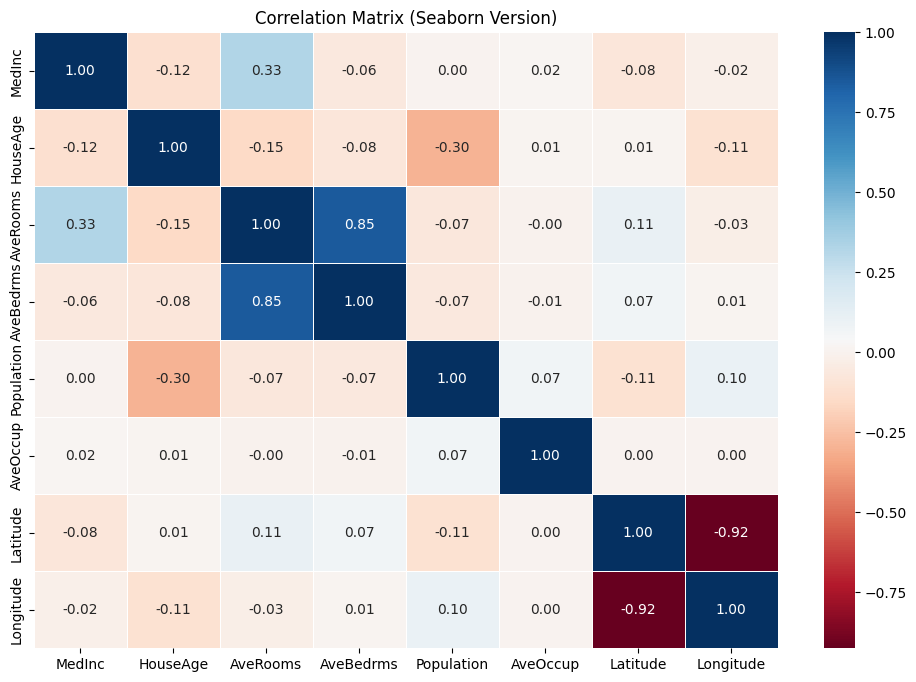

In [84]:
# Visualize the correlation matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Seaborn Version)')
plt.show()

In [85]:
#note: we don't need to standarize the data for tree-based models like XGBoost because they are not sensitive to the scale of the features.

In [86]:
#create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
#train an xgboost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [88]:
#get the predictions
y_pred = xgb_model.predict(X_train)

In [89]:
#train the surrogate model now with the decision tree regressor and the predictions from the xgboost model
surrogate_model = DecisionTreeRegressor(max_depth=4, random_state=42)
surrogate_model.fit(X_train, y_pred)

DecisionTreeRegressor(max_depth=4, random_state=42)

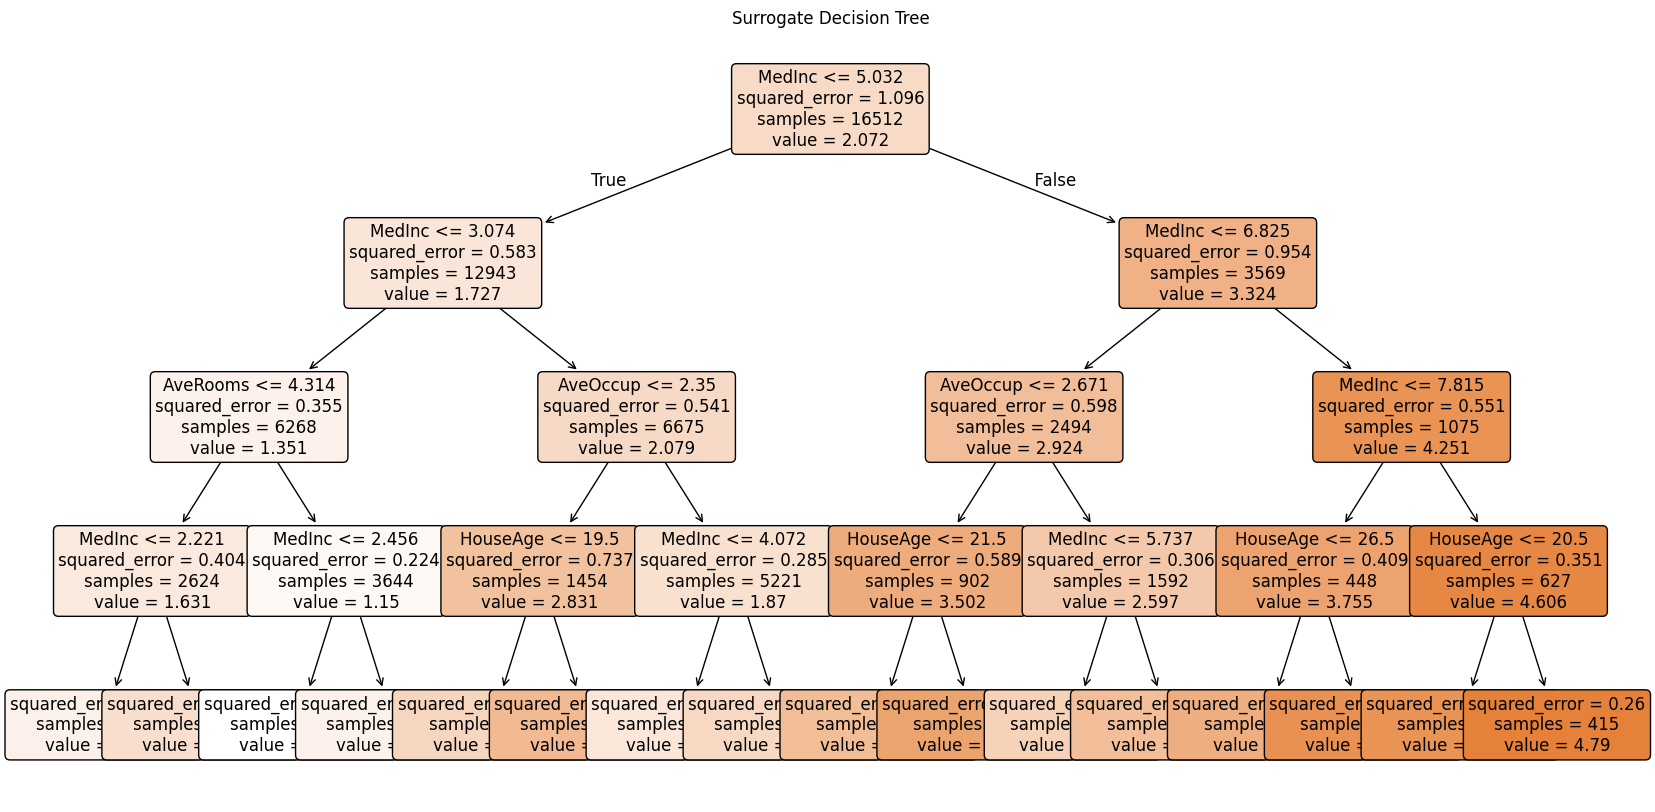

In [90]:
#make a global explanation by visualizing the decision tree
plt.figure(figsize=(20,10))
plot_tree(surrogate_model, feature_names=X.columns, filled=True, rounded=True, fontsize=12)
plt.title('Surrogate Decision Tree')
plt.show()

In [91]:
#make a local explanation for a specific instance
instance_index = 0  
instance = X_test.iloc[[instance_index]]
predicted_value = xgb_model.predict(instance)
surrogate_prediction = surrogate_model.predict(instance)

In [92]:
#print now the results
print(f"Instance to explain (index {instance_index}):")
print(instance)
print(f"\nXGBoost Model Prediction: {predicted_value[0]}")
print(f"Surrogate Model Prediction: {surrogate_prediction[0]}")

Instance to explain (index 0):
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
20046  1.6812      25.0  4.192201   1.022284      1392.0  3.877437     36.06   

       Longitude  
20046    -119.01  

XGBoost Model Prediction: 0.4833424687385559
Surrogate Model Prediction: 1.3755852161992526


In [93]:
surrogate_model.tree_.threshold

array([ 5.03164983,  3.07429993,  4.31418896,  2.22130001, -2.        ,
       -2.        ,  2.45630002, -2.        , -2.        ,  2.3495177 ,
       19.5       , -2.        , -2.        ,  4.07185006, -2.        ,
       -2.        ,  6.82504988,  2.67065752, 21.5       , -2.        ,
       -2.        ,  5.73714995, -2.        , -2.        ,  7.81515002,
       26.5       , -2.        , -2.        , 20.5       , -2.        ,
       -2.        ])

In [94]:
#explaination  of  why the surrogate model made that prediction by visualizing the decision path 
node_indicator = surrogate_model.decision_path(instance)
leaf_id = surrogate_model.apply(instance)
feature = surrogate_model.tree_.feature
threshold = surrogate_model.tree_.threshold

print("\nDecision path:")
node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]      
for node_id in node_index:
    if leaf_id[0] == node_id:
        print(f"Leaf node {node_id} reached.")
        continue

    if instance.iloc[0, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(f"Node {node_id}: (feature '{X.columns[feature[node_id]]}' = {instance.iloc[0, feature[node_id]]}) "
          f"{threshold_sign} {threshold[node_id]}") 


Decision path:
Node 0: (feature 'MedInc' = 1.6812) <= 5.031649827957153
Node 1: (feature 'MedInc' = 1.6812) <= 3.074299931526184
Node 2: (feature 'AveRooms' = 4.192200557103064) <= 4.3141889572143555
Node 3: (feature 'MedInc' = 1.6812) <= 2.2213000059127808
Leaf node 4 reached.


In [95]:
#check the value at the leaf node
leaf_value = surrogate_model.tree_.value[leaf_id[0]]
print(f"\nValue at leaf node {leaf_id[0]}: {leaf_value[0][0]}")


Value at leaf node 4: 1.3755852161992526


# HOMERWORK 2:
